In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point

# Pittsburgh Crash Data
![Cars](img/crash.gif)


Here we are importing only the columns we need from the crash dataset. Because the dataset is missing neighborhood information, we need to use the provided latitude and longitude to determine which neighborhood the crash occurred in. We filter out any rows missing data and exclude crashes that occur between neighborhoods (usually crashes on bridges). This reduces our dataset from 216,000 entries to 70,000. The output is saved as a new .csv because this process takes 30+ minutes to complete.

In [3]:
# DO NOT RUN: output is already saved as Crash_Data_Neighborhood.csv
crashes = pd.read_csv('Crash_Data.csv', usecols = ["DEC_LAT","DEC_LONG","DRINKING_DRIVER","CELL_PHONE","RUNNING_RED_LT","AGGRESSIVE_DRIVING","DISTRACTED","DRUGGED_DRIVER","ILLEGAL_DRUG_RELATED","RUNNING_STOP_SIGN"])
crashes = crashes.dropna(subset=["DEC_LAT","DEC_LONG"])

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods.shp")

def get_neighborhood(lat, long):
    crash_loc = Point(map(float, (long, lat)))
    # Loop through each of the 90 neighborhoods and check if the coordinate is within its bounds
    for i, neighborhood in neighborhoods.iterrows():
        if neighborhood["geometry"].contains(crash_loc):
            return neighborhood["hood"]
    return None

crashes["NEIGHBORHOOD"] = crashes.apply(lambda row: get_neighborhood(row.DEC_LAT, row.DEC_LONG), axis=1)
crashes = crashes.dropna(subset=["NEIGHBORHOOD"]) # remove any crashes outside of a neighborhood (usually crashes on bridges)
crashes.to_csv(path_or_buf = "Crash_Data_Neighborhood.csv")

KeyboardInterrupt: 

In [2]:
crashes = pd.read_csv('Crash_Data_Neighborhood.csv')
crashes = crashes.dropna()

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods.shp")

# Separate data into sub-metrics
impaired = crashes[["DRINKING_DRIVER","DRUGGED_DRIVER","ILLEGAL_DRUG_RELATED","CELL_PHONE","DISTRACTED"]]
psychopath = crashes[["RUNNING_RED_LT","RUNNING_STOP_SIGN","AGGRESSIVE_DRIVING"]]

#Drop sub-metrics from main dataset
crashes = crashes[["NEIGHBORHOOD"]]

## Driver Personality Analysis
![Driver compass](img/driver_compass.png)

Now we split the crashes data into indicators of impairedness and psychopathy. Especially egregious behaviors are rewardeed more points which are then tallied into a combined danger score.

In [3]:
# Max Score: 8
crashes["IMPAIRED_SCORE"] = impaired.apply(lambda row: row.DISTRACTED + row.DRUGGED_DRIVER + 2*row.CELL_PHONE + 2*row.DRINKING_DRIVER + 2*row.ILLEGAL_DRUG_RELATED, axis=1)

# Max Score: 6
crashes["PSYCHOPATH_SCORE"] = psychopath.apply(lambda row: 2*row.RUNNING_RED_LT + 2*row.RUNNING_STOP_SIGN + 2*row.AGGRESSIVE_DRIVING, axis=1)

# Max Score: 14
crashes["DANGER_SCORE"] = crashes.apply(lambda row: row.IMPAIRED_SCORE + row.PSYCHOPATH_SCORE, axis=1)

crashes.head()

,NEIGHBORHOOD,IMPAIRED_SCORE,PSYCHOPATH_SCORE,DANGER_SCORE
0,Fineview,0,1,1
1,Lower Lawrenceville,0,2,2
2,Oakwood,0,1,1
3,Oakwood,0,2,2
4,Point Breeze,0,1,1


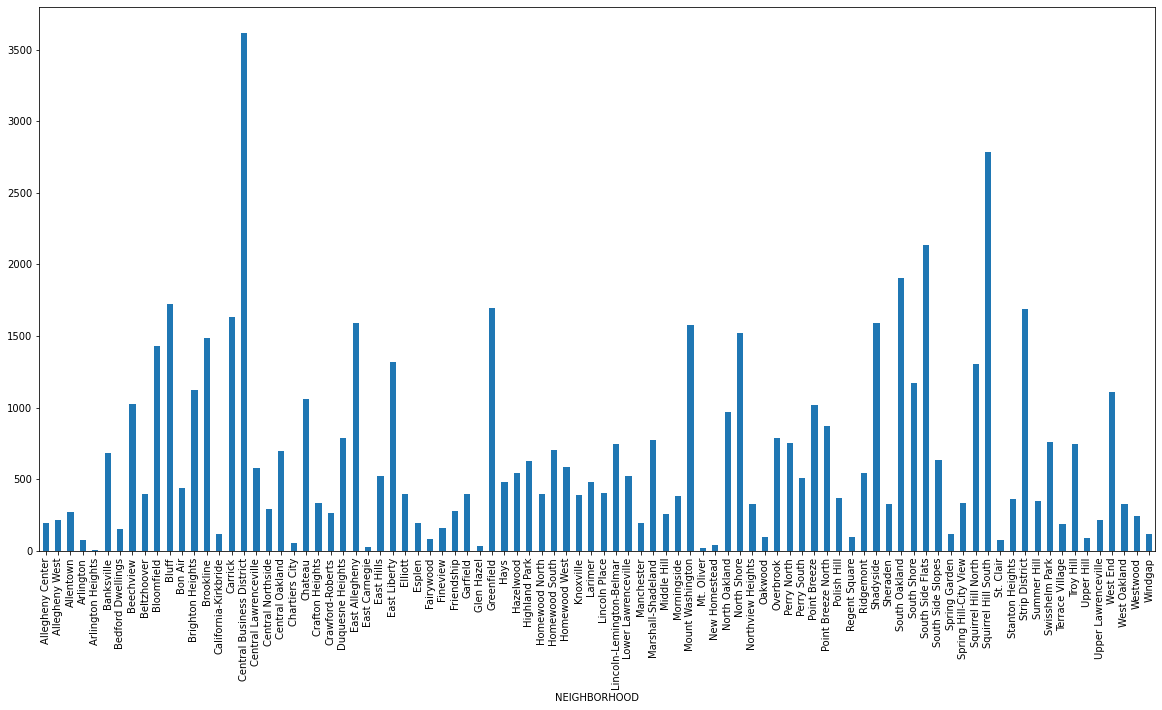

In [7]:
crashes = crashes.groupby("NEIGHBORHOOD").sum()
crashes["DANGER_SCORE"].plot.bar(figsize = (20,10))

In [8]:
# Use daily traffic to divide danger score
#crashes.merge()
crashes["DANGER_SCORE"] = crashes.apply(lambda row: row.DANGER_SCORE / )

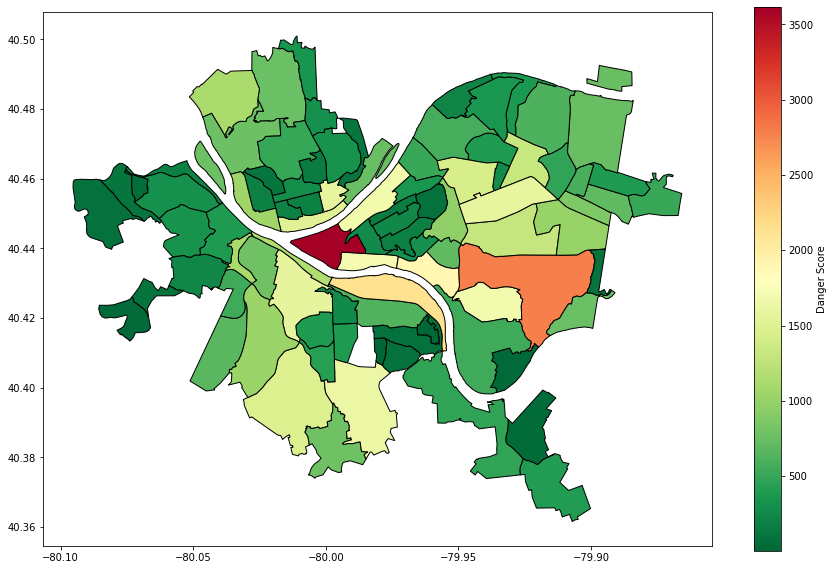

In [12]:
crash_map = neighborhoods.merge(crashes, how="left", left_on="hood", right_on="NEIGHBORHOOD")
crash_map.plot(column="DANGER_SCORE",
               cmap="RdYlGn_r",
               edgecolor="black",
               legend=True,
               legend_kwds={"label": "Danger Score"},
               figsize=(15, 10))